In [90]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt
from PIL import Image

데이터셋 연결 확인

In [91]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "data/train/DCM"
LABEL_ROOT = "data/train/outputs_json"

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

IND2CLASS = {v: k for k, v in CLASS2IND.items()}

pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

print(f'len(pngs): {len(pngs)}, len(jsons): {len(jsons)}')



len(pngs): 800, len(jsons): 800


모든 .png 파일에 대해 .json pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.

In [92]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

In [93]:
pngs = sorted(pngs)
jsons = sorted(jsons)

Define Dataset Class

In [94]:
class XRayDataset(Dataset):
    def __init__(self, transforms=None):
        # 전체 파일을 filenames와 labelnames에 넣습니다.
        self.filenames = pngs
        self.labelnames = jsons
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # (H, W, NC) 모양의 label 생성
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # label 파일 읽기
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # 클래스 별로 처리
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon 포맷을 dense한 mask 포맷으로 바꾸기
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"]

        # to tensor
        image = image.transpose(2, 0, 1)
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label


In [95]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [96]:
dataset = XRayDataset()

In [97]:
image, label = dataset[0]
print(image.shape, label.shape)
len(dataset)

torch.Size([3, 2048, 2048]) torch.Size([29, 2048, 2048])


800

채널이 3인데, 차이 확인

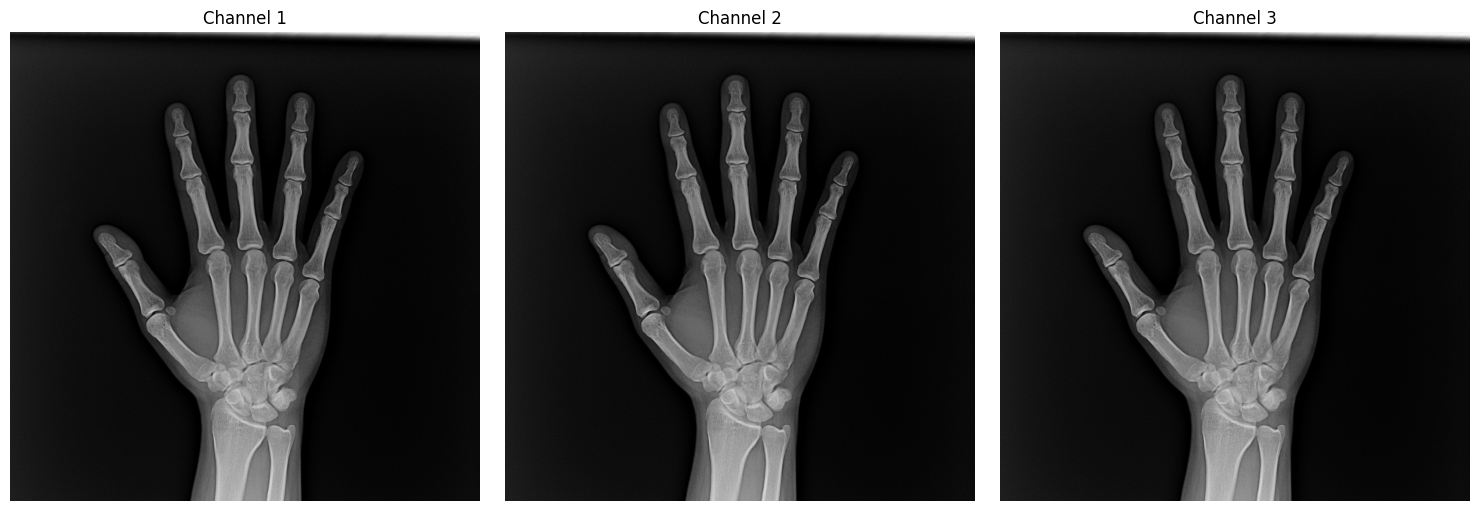

In [98]:
import matplotlib.pyplot as plt

# 첫 번째 샘플에서 image만 가져오기
image, label = dataset[622]

# 이미지 출력 (채널 3개를 모두 출력하려면 각 채널별로 시각화)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 채널별로 이미지 출력 (예: RGB 채널)
for i in range(3):
    ax[i].imshow(image[i], cmap='gray')  # 각 채널을 grayscale로 출력
    ax[i].set_title(f"Channel {i+1}")
    ax[i].axis('off')  # 축을 숨김

plt.tight_layout()
plt.show()


3개의 이미지를 합쳐서 보기

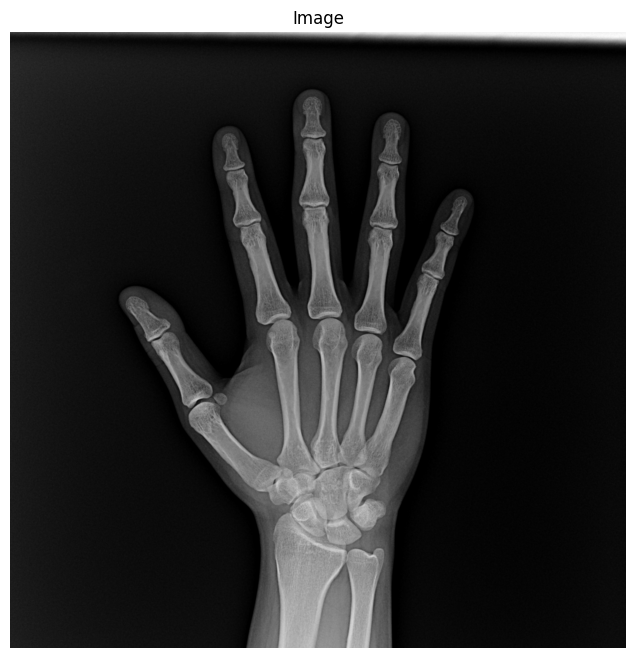

In [99]:
# (3, height, width)를 (height, width, 3)로 변환
image = image.permute(1, 2, 0).numpy()

# 이미지 출력
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title("Image")
plt.axis('off')  # 축을 숨김
plt.show()


In [100]:
import numpy as np

# 각 채널의 고유 값 확인
unique_channel1 = np.unique(image[0])
unique_channel2 = np.unique(image[1])
unique_channel3 = np.unique(image[2])

print(f"Channel 1 unique values: {unique_channel1}")
print(f"Channel 2 unique values: {unique_channel2}")
print(f"Channel 3 unique values: {unique_channel3}")


Channel 1 unique values: [0.25490198 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.32941177 0.33333334 0.3372549  0.34117648 0.34509805 0.34901962
 0.3529412  0.35686275 0.36078432 0.3647059  0.36862746 0.37254903
 0.3764706  0.38039216 0.38431373 0.3882353  0.39215687 0.39607844
 0.4        0.40392157 0.40784314 0.4117647  0.41568628 0.41960785
 0.42352942 0.42745098 0.43137255 0.43529412 0.4392157  0.44313726
 0.44705883 0.4509804  0.45490196 0.45882353 0.4627451  0.46666667
 0.47058824 0.4745098  0.47843137 0.48235294 0.4862745  0.49019608
 0.49411765 0.49803922 0.5019608  0.5058824  0.50980395 0.5137255
 0.5176471  0.52156866 0.5254902  0.5294118  0.53333336 0.5372549
 0.5411765  0.54509807 0.54901963 0.5529412  0.5568628  0.56078434
 0.5647059  0.5686275  0.57254905 0.5764706  0.5803922  0.58431375
 0.5882353  0.5921569  0.59607846 0.6     

           Channel1      Channel2      Channel3
count  4.194304e+06  4.194304e+06  4.194304e+06
mean   1.103314e-01  1.103314e-01  1.103314e-01
std    1.852224e-01  1.852224e-01  1.852224e-01
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    1.568628e-02  1.568628e-02  1.568628e-02
50%    3.921569e-02  3.921569e-02  3.921569e-02
75%    6.274510e-02  6.274510e-02  6.274510e-02
max    1.000000e+00  1.000000e+00  1.000000e+00
Channel 1 unique count: 181
Channel 2 unique count: 189
Channel 3 unique count: 193
Correlation between (0, 1) channels: 0.9999999999999999
Correlation between (1, 2) channels: 0.9999999999999999
Correlation between (2, 0) channels: 0.9999999999999999
Sum of Correlation: 2.9999999999999996


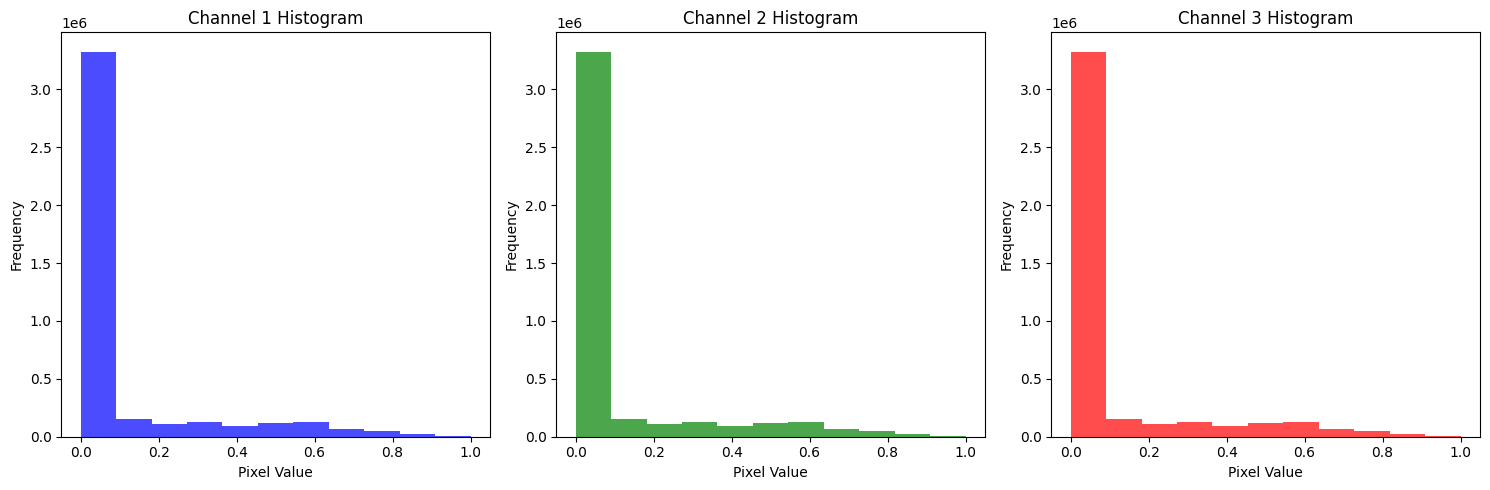

In [101]:
image, label = dataset[0]

# 이미지 채널이 numpy 배열인지 확인
if isinstance(image, np.ndarray):
    channel1 = image[0].flatten()
    channel2 = image[1].flatten()
    channel3 = image[2].flatten()
else:
    # 각 채널을 numpy 배열로 변환 후 describe() 사용
    channel1 = image[0].numpy().flatten()
    channel2 = image[1].numpy().flatten()
    channel3 = image[2].numpy().flatten()

# DataFrame에 각 채널을 넣고 describe() 사용
channels_df = pd.DataFrame({
    'Channel1': channel1,
    'Channel2': channel2,
    'Channel3': channel3
})

# describe() 사용해서 통계 요약 보기
channel_stats = channels_df.describe()

print(channel_stats)

# 각 채널의 픽셀 고유 값 개수 확인
print(f"Channel 1 unique count: {len(unique_channel1)}")
print(f"Channel 2 unique count: {len(unique_channel2)}")
print(f"Channel 3 unique count: {len(unique_channel3)}")

# 채널 간의 상관계수 계산
corr_01 = np.corrcoef(image[0].flatten(), image[1].flatten())[0, 1]  
corr_12 = np.corrcoef(image[1].flatten(), image[2].flatten())[0, 1]  
corr_20 = np.corrcoef(image[0].flatten(), image[2].flatten())[0, 1] 

print(f"Correlation between (0, 1) channels: {corr_01}")
print(f"Correlation between (1, 2) channels: {corr_12}")
print(f"Correlation between (2, 0) channels: {corr_20}")

print(f"Sum of Correlation: {corr_01 + corr_12 + corr_20}")


# 각 채널의 히스토그램을 출력
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 각 채널에 대해 다른 색상을 지정
colors = ['blue', 'green', 'red']

for i in range(3):
    ax[i].hist(image[i].flatten(), bins=11, color=colors[i], alpha=0.7)
    ax[i].set_title(f"Channel {i+1} Histogram")
    ax[i].set_xlabel('Pixel Value')
    ax[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


모든 이미지가 3개의 채널을 가지고 있는지 확인

In [184]:
# 3개의 채널을 가진 이미지가 있는지 확인
for idx, (image, label) in enumerate(dataset):
    # 이미지가 3채널을 가지고 있는지, 모두 같은 size를 가지고 있는지 확인
    if image.shape == [3, 2048, 2048]:
        print(f"Image {idx} has {image.shape}")
    if idx % 100 == 0:
        print(idx)


0
100
200
300
400
500
600
700


Processed 0 images
Processed 20 images
Processed 40 images
Processed 60 images
Processed 80 images
Processed 100 images
Processed 120 images
Processed 140 images
Processed 160 images
Processed 180 images
Processed 200 images
Processed 220 images
Processed 240 images
Processed 260 images
Processed 280 images
Processed 300 images
Processed 320 images
Processed 340 images
Processed 360 images
Processed 380 images
Processed 400 images
Processed 420 images
Processed 440 images
Processed 460 images
Processed 480 images
Processed 500 images
Processed 520 images
Processed 540 images
Processed 560 images
Processed 580 images
Processed 600 images
Processed 620 images
Processed 640 images
Processed 660 images
Processed 680 images
Processed 700 images
Processed 720 images
Processed 740 images
Processed 760 images
Processed 780 images


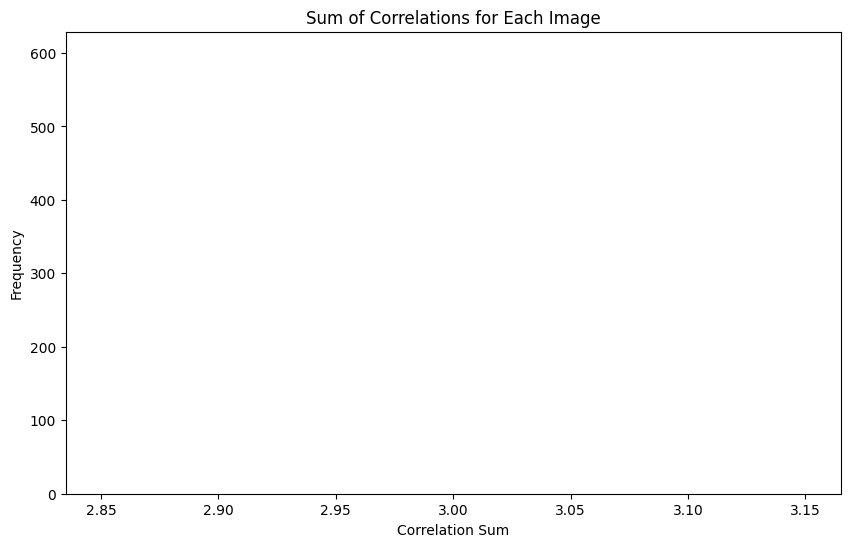

In [ ]:
# train_dataset의 모든 이미지에 대해 채널 간 상관계수 합을 계산
corr_sum_list = []

# 각 이미지의 크기를 확인하고, 문제를 파악 
for idx, (image, label) in enumerate(dataset):
    # 각 채널을 플래튼 후 상관계수 계산 및 NaN 처리
    img0_fla = image[0].ravel()
    img1_fla = image[1].ravel()
    img2_fla = image[2].ravel()

    corr_01 = np.nan_to_num(np.corrcoef(img0_fla, img1_fla)[0, 1])
    corr_12 = np.nan_to_num(np.corrcoef(img1_fla, img2_fla)[0, 1])
    corr_20 = np.nan_to_num(np.corrcoef(img0_fla, img2_fla)[0, 1])

    corr_sum = corr_01 + corr_12 + corr_20
    corr_sum_list.append(corr_sum)

    if idx % 20 == 0:
        print(f"Processed {idx} images")


In [ ]:
mean_corr = np.mean(corr_sum_list)
std_corr = np.std(corr_sum_list)
min_corr = np.min(corr_sum_list)
max_corr = np.max(corr_sum_list)

print("Mean:", mean_corr)
print("Std Deviation:", std_corr)
print("Min:", min_corr)


Mean: 3.0
Std Deviation: 3.8169719468841477e-16
Min: 2.999999999999999
